In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
msambare_fer2013_path = kagglehub.dataset_download('msambare/fer2013')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

/tmp/ipykernel_55/3330320704.py:7: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr
2026-01-30 10:40:30.941978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769769631.397635      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769769631.523447      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769769632.661487      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769769632.661534      55 computation_placer.cc:177] computation placer already registered. Please check linkage and a

In [ ]:
os.makedirs('test_dir', exist_ok=True)

In [ ]:
project_name = 'Emotion_Detection'

model_names = [
    'CNN1',
    'CNN2_With_Augmentation',
    'CNN3_VGG16',
    'CNN4_ResNet50'
]

base_dir = '/kaggle/working/'

project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)

print(f'Project directory structure created at: {project_dir}')


Project directory structure created at: /kaggle/working/Emotion_Detection


In [ ]:
image_exts = ['jpeg', 'jpg', 'png']

data_dir = '/kaggle/input/fer2013/train'

for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            file_type = imghdr.what(file_path)

            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:

                img = cv2.imread(file_path)

        except Exception as e:
            print(f'Issue with file {file_path}. Error: {e}')
            os.remove(file_path)

In [ ]:
def count_files_in_subdirs(directory, set_name):
    counts = {}

    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)

        if os.path.isdir(item_path):
            counts[item] = len(os.listdir(item_path))


    df = pd.DataFrame(counts, index=[set_name])
    return df

train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'

train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)

       surprise  fear  angry  neutral   sad  disgust  happy
train      3171  4097   3995     4965  4830      436   7215
      surprise  fear  angry  neutral   sad  disgust  happy
test       831  1024    958     1233  1247      111   1774


<Axes: >

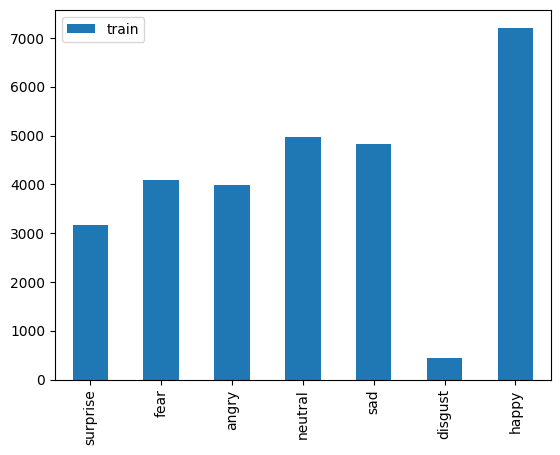

In [ ]:
train_count.transpose().plot(kind='bar')

<Axes: >

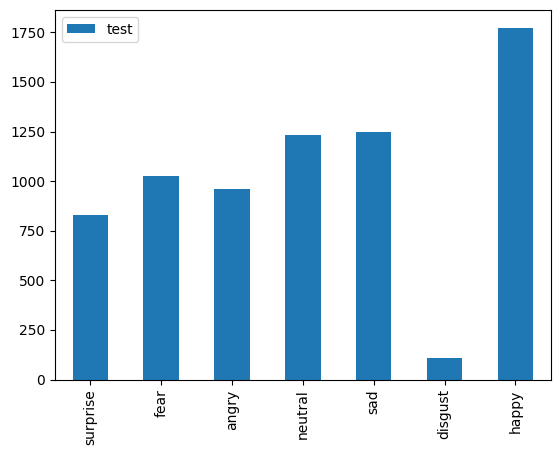

In [ ]:
test_count.transpose().plot(kind='bar')

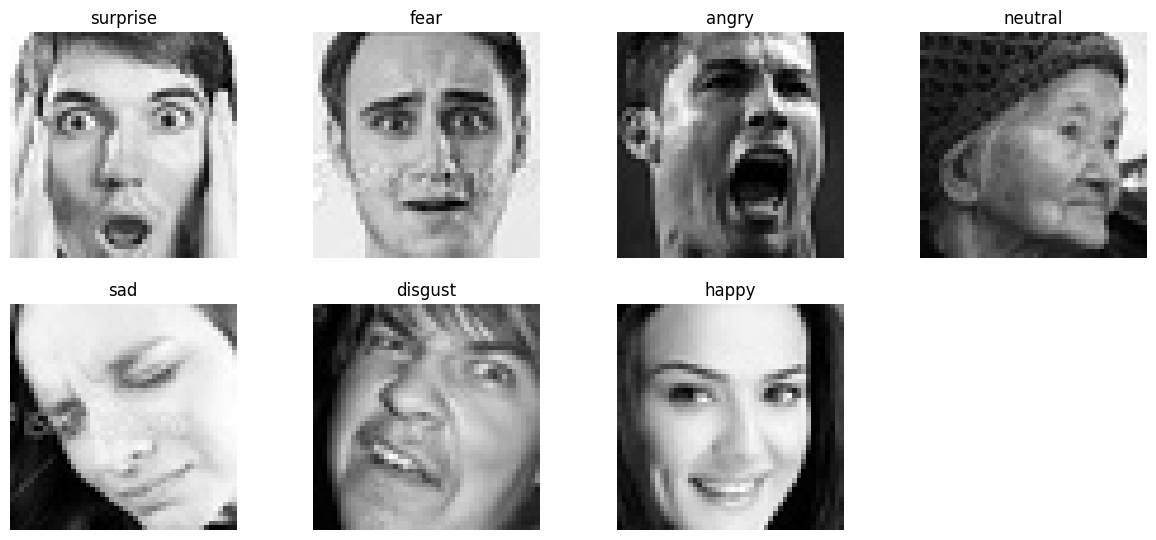

In [ ]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

In [ ]:
def plot_images_from_directory(directory_path, class_name, num_images=9):

    image_filenames = os.listdir(directory_path)


    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    selected_images = random.sample(image_filenames, num_images)

    fig, axes = plt.subplots(3, 3, figsize=(5, 5))
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)

        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

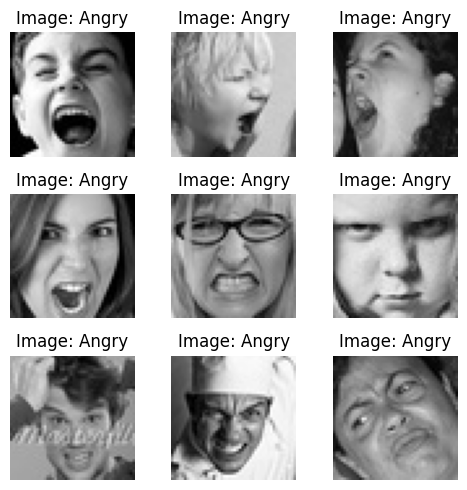

In [ ]:
angry_directory_path = '/kaggle/input/fer2013/train/angry'
plot_images_from_directory(angry_directory_path, class_name = 'Angry')

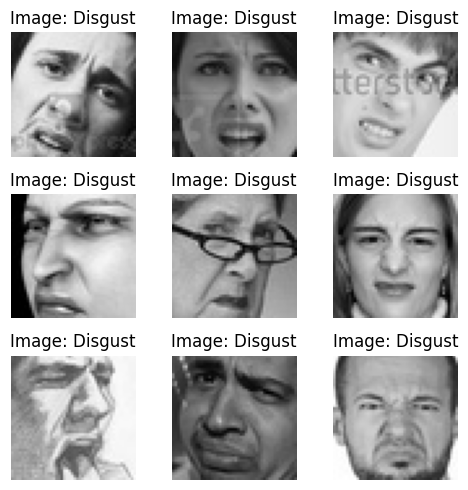

In [ ]:
disgust_directory_path = '/kaggle/input/fer2013/train/disgust'
plot_images_from_directory(disgust_directory_path, class_name = 'Disgust')

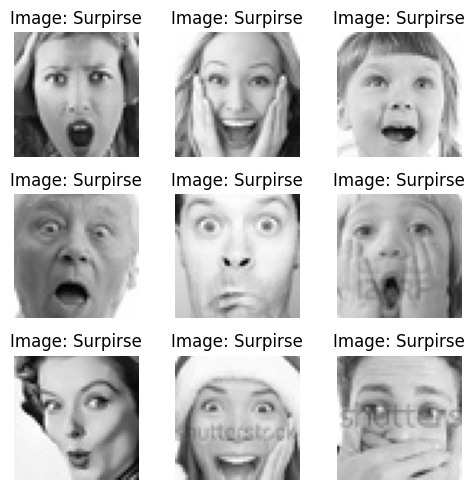

In [ ]:
surpirse_directory_path = '/kaggle/input/fer2013/train/surprise'
plot_images_from_directory(surpirse_directory_path, class_name = 'Surpirse')

In [ ]:
image = '/kaggle/input/fer2013/train/angry/Training_10118481.jpg'

import cv2

img = cv2.imread(image)


if img is not None:

    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48, 3)


In [ ]:
import cv2

image_path = '/kaggle/input/fer2013/train/angry/Training_10118481.jpg'

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


if img is not None:

    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48)


In [ ]:
train_data_dir = '/kaggle/input/fer2013/train'
test_data_dir = '/kaggle/input/fer2013/test'

In [ ]:
img_width, img_height = 48, 48
batch_size = 64
epochs = 15
num_classes = 7

In [ ]:
# Rescaling the pixel values (0-255) to the [0, 1] interval..
data_generator = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)


train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)

test_class_labels = test_generator.class_indices
print("Validation class labels:", test_class_labels)

Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
CNN1 = Sequential()

CNN1.add(Conv2D(32, kernel_size=(3,3),kernel_initializer="glorot_uniform", padding='same',input_shape=(img_width, img_height, 1)))
CNN1.add(Activation('relu'))
CNN1.add(Conv2D(64, kernel_size=(3,3), padding='same'))
CNN1.add(Activation('relu'))
CNN1.add(BatchNormalization())
CNN1.add(MaxPooling2D(2,2))
CNN1.add(Dropout(0.25))

CNN1.add(Conv2D(128, kernel_size=(3,3), padding='same',kernel_regularizer=regularizers.l2(0.01)))
CNN1.add(Activation('relu'))
CNN1.add(Conv2D(256, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.01)))
CNN1.add(Activation('relu'))
CNN1.add(BatchNormalization())
CNN1.add(MaxPooling2D(pool_size=(3,3)))
CNN1.add(Dropout(0.25))

CNN1.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
CNN1.add(Activation('relu'))
CNN1.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
CNN1.add(Activation('relu'))
CNN1.add(BatchNormalization())
CNN1.add(MaxPooling2D(pool_size=(2, 2)))
CNN1.add(Dropout(0.25))

CNN1.add(Flatten())
CNN1.add(Dense(1024))
CNN1.add(Activation('relu'))
CNN1.add(Dropout(0.5))

CNN1.add(Dense(num_classes))
CNN1.add(Activation('softmax'))

In [ ]:
CNN1.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 7, 7, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,657,927 (33.03 MB)

 Trainable params: 8,656,263 (33.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [ ]:
CNN1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

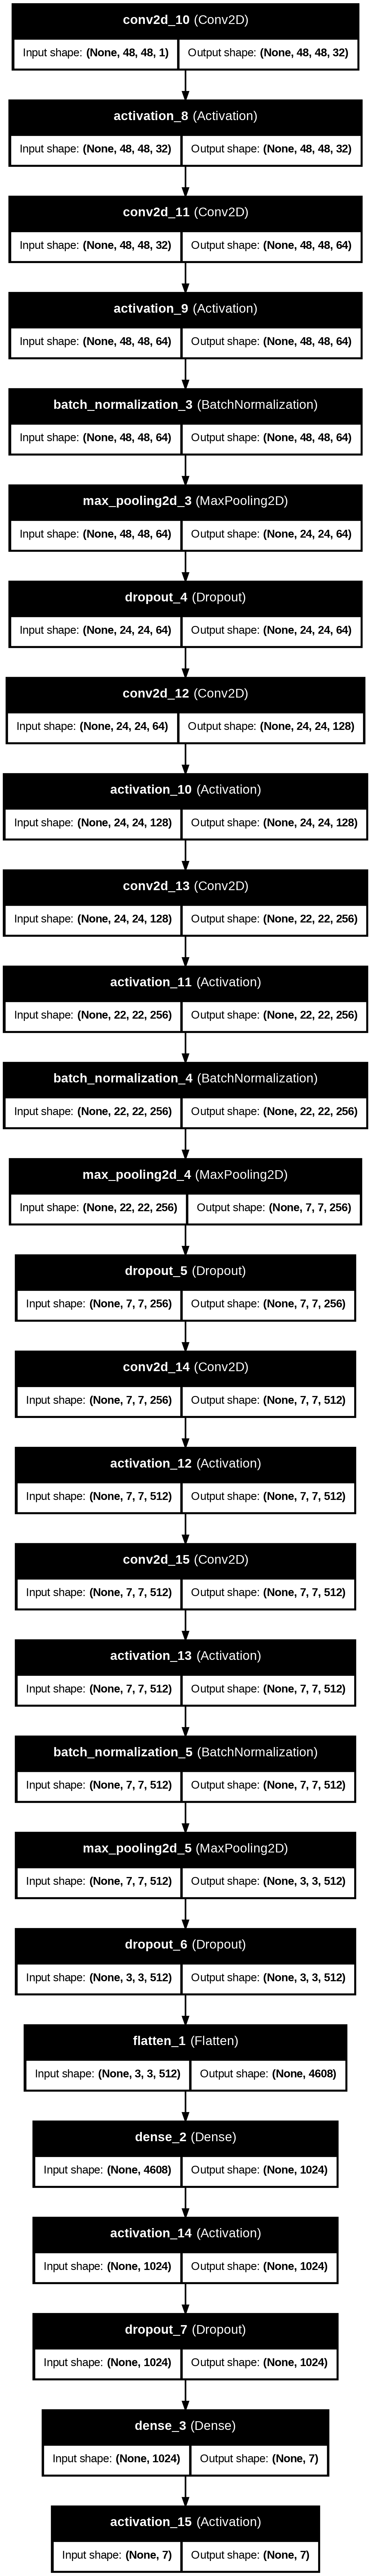

In [ ]:
plot_model(CNN1, to_file = '/kaggle/working/Emotion_Detection/CNN1/Architecture.png',
           show_shapes=True, show_layer_names=True)

In [ ]:
cnn_path = '/kaggle/working/Emotion_Detection/CNN1'
name = 'CNN1.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'/kaggle/working/Emotion_Detection/CNN1/CNN1.keras'

In [ ]:
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

In [ ]:
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

In [ ]:
# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

In [ ]:
# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

In [ ]:
train_generator.samples

22968

In [ ]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
history_CNN1 = CNN1.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=13,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/13


I0000 00:00:1769774810.815566     836 service.cc:152] XLA service 0x7d523c017290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769774810.815603     836 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1769774810.815607     836 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1769774811.906188     836 cuda_dnn.cc:529] Loaded cuDNN version 91002


  2/359 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.1094 - loss: 16.1792   

I0000 00:00:1769774823.773797     836 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.2308 - loss: 13.2308
Epoch 1: val_loss improved from inf to 16.43562, saving model to /kaggle/working/Emotion_Detection/CNN1/CNN1.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 85s 192ms/step - accuracy: 0.2309 - loss: 13.2284 - val_accuracy: 0.0152 - val_loss: 16.4356 - learning_rate: 1.0000e-04
Epoch 2/13
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.3263 - loss: 10.5796
Epoch 2: val_loss improved from 16.43562 to 9.33179, saving model to /kaggle/working/Emotion_Detection/CNN1/CNN1.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 77s 214ms/step - accuracy: 0.3264 - loss: 10.5781 - val_accuracy: 0.3484 - val_loss: 9.3318 - learning_rate: 1.0000e-04
Epoch 3/13
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.3812 - loss: 8.4830
Epoch 3: val_loss improved from 9.33179 to 7.29892, saving model to /kaggle/working/Emotion_Detection/CNN1/CNN1.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 72s 200ms/step - accuracy: 0.3812 - loss: 8.4817 - val_accuracy: 

**Plotting Metrics:**

In [ ]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history_CNN1.history['accuracy']
    val_acc = history_CNN1.history['val_accuracy']
    loss = history_CNN1.history['loss']
    val_loss = history_CNN1.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

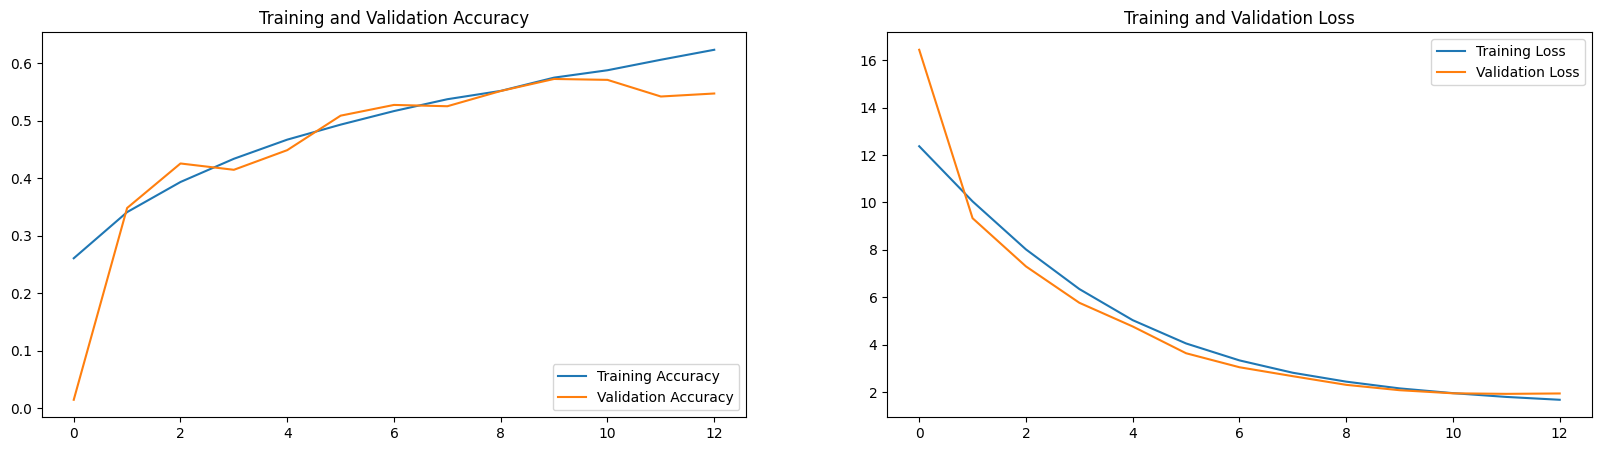

In [ ]:
plot_training_history(history_CNN1)

**Model Evaluation:**

In [ ]:
train_loss, train_acc = CNN1.evaluate(train_generator)
test_loss, test_acc = CNN1.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 97ms/step - accuracy: 0.6079 - loss: 1.7058
113/113 ━━━━━━━━━━━━━━━━━━━━ 48s 421ms/step - accuracy: 0.5484 - loss: 1.9280
final train accuracy = 61.24 , validation accuracy = 54.69


**Plotting Confusion Matrix:**

113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step


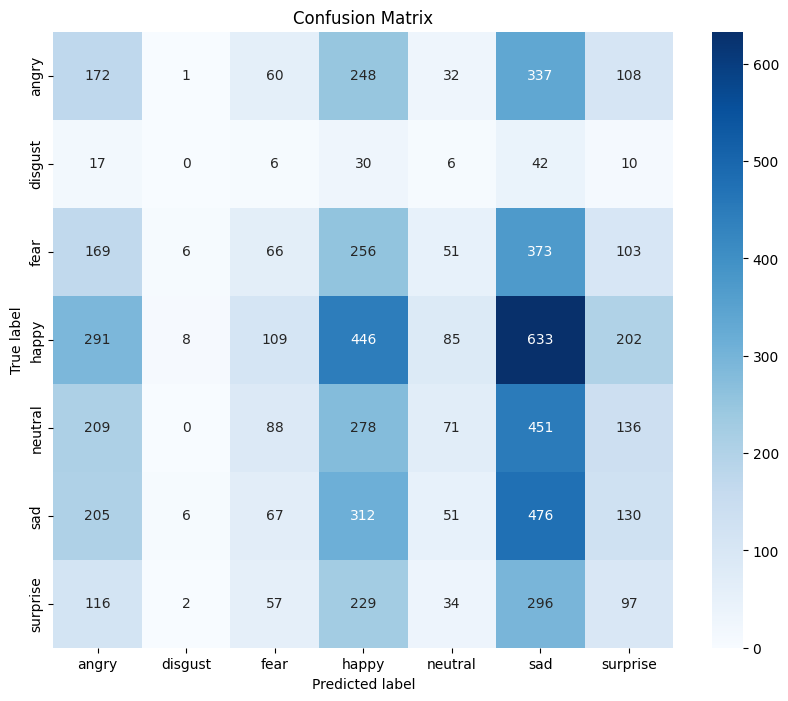

In [ ]:
true_classes = test_generator.classes
predicted_classes = np.argmax(
    CNN1.predict(
        test_generator,
        steps=int(np.ceil(test_generator.samples / test_generator.batch_size))
    ),
    axis=1
)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.15      0.18      0.16       958
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.06      0.09      1024
       happy       0.25      0.25      0.25      1774
     neutral       0.22      0.06      0.09      1233
         sad       0.18      0.38      0.25      1247
    surprise       0.12      0.12      0.12       831

    accuracy                           0.19      7178
   macro avg       0.15      0.15      0.14      7178
weighted avg       0.18      0.19      0.17      7178



* By seeing this report and also the confusion matrix, it can ve said that the model is not performing well.

**Making Predictions:**

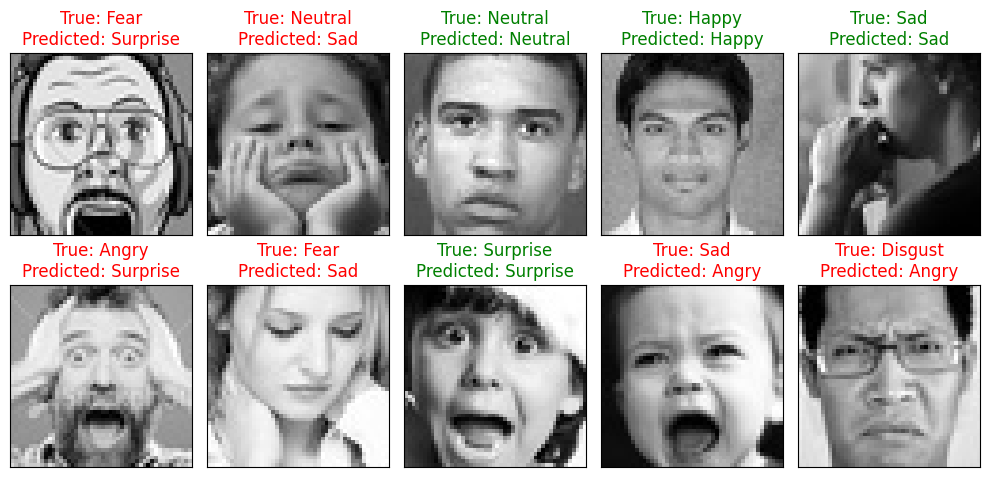

In [ ]:
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

batch_size = test_generator.batch_size

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    CNN1_Prediction = np.argmax(CNN1.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    ax.imshow(Random_Img.squeeze(), cmap='gray')

    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[CNN1_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[CNN1_Prediction]}", color=color)

plt.tight_layout()
plt.show()

**For better model: Using data augumentation(CNN Model No.2):**

In [ ]:
data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_data_generator = ImageDataGenerator(rescale=1./255)



train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
    )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


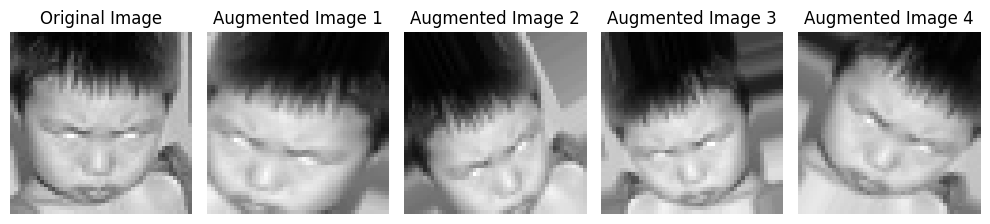

In [ ]:

image_path = '/kaggle/input/fer2013/train/angry/Training_10118481.jpg'


img = load_img(image_path, color_mode='grayscale', target_size=(img_width, img_height))
img_array = img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))

axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

for i, ax in enumerate(axes.flat[1:]):

    aug_iter = data_generator.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]


    ax.imshow(aug_img[:, :, 0], cmap='gray')
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
img_width, img_height = 48, 48
classes = 7

CNN2 = tf.keras.models.Sequential()


CNN2.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
CNN2.add(tf.keras.layers.Activation('relu'))
CNN2.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
CNN2.add(tf.keras.layers.Activation('relu'))
CNN2.add(BatchNormalization())
CNN2.add(MaxPooling2D(2, 2))
CNN2.add(Dropout(0.25))

CNN2.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
CNN2.add(tf.keras.layers.Activation('relu'))
CNN2.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
CNN2.add(tf.keras.layers.Activation('relu'))
CNN2.add(BatchNormalization())
CNN2.add(MaxPooling2D(pool_size=(2, 2)))
CNN2.add(Dropout(0.25))

CNN2.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
CNN2.add(tf.keras.layers.Activation('relu'))
CNN2.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
CNN2.add(tf.keras.layers.Activation('relu'))
CNN2.add(BatchNormalization())
CNN2.add(MaxPooling2D(pool_size=(2, 2)))
CNN2.add(Dropout(0.25))

CNN2.add(Flatten())
CNN2.add(Dense(1024))
CNN2.add(tf.keras.layers.Activation('relu'))
CNN2.add(Dropout(0.5))

CNN2.add(Dense(classes))
CNN2.add(tf.keras.layers.Activation('softmax'))


CNN2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


cnn_path = '/kaggle/working/Emotion_Detection/CNN2_With_Augmentation'
name = 'CNN2.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

history_CNN2 = CNN2.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.2060 - loss: 13.4039
Epoch 1: val_loss improved from inf to 13.00647, saving model to /kaggle/working/Emotion_Detection/CNN2_With_Augmentation/CNN2.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 118s 305ms/step - accuracy: 0.2061 - loss: 13.4013 - val_accuracy: 0.1709 - val_loss: 13.0065 - learning_rate: 1.0000e-04
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.2416 - loss: 10.7365
Epoch 2: val_loss improved from 13.00647 to 9.89214, saving model to /kaggle/working/Emotion_Detection/CNN2_With_Augmentation/CNN2.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 62s 173ms/step - accuracy: 0.2416 - loss: 10.7350 - val_accuracy: 0.2304 - val_loss: 9.8921 - learning_rate: 1.0000e-04
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.2484 - loss: 8.5353
Epoch 3: val_loss improved from 9.89214 to 7.39975, saving model to /kaggle/working/Emotion_Detection/CNN2_With_Augmentation/CNN2.keras
359/359 ━━━━━━━━━━━━━━━━━

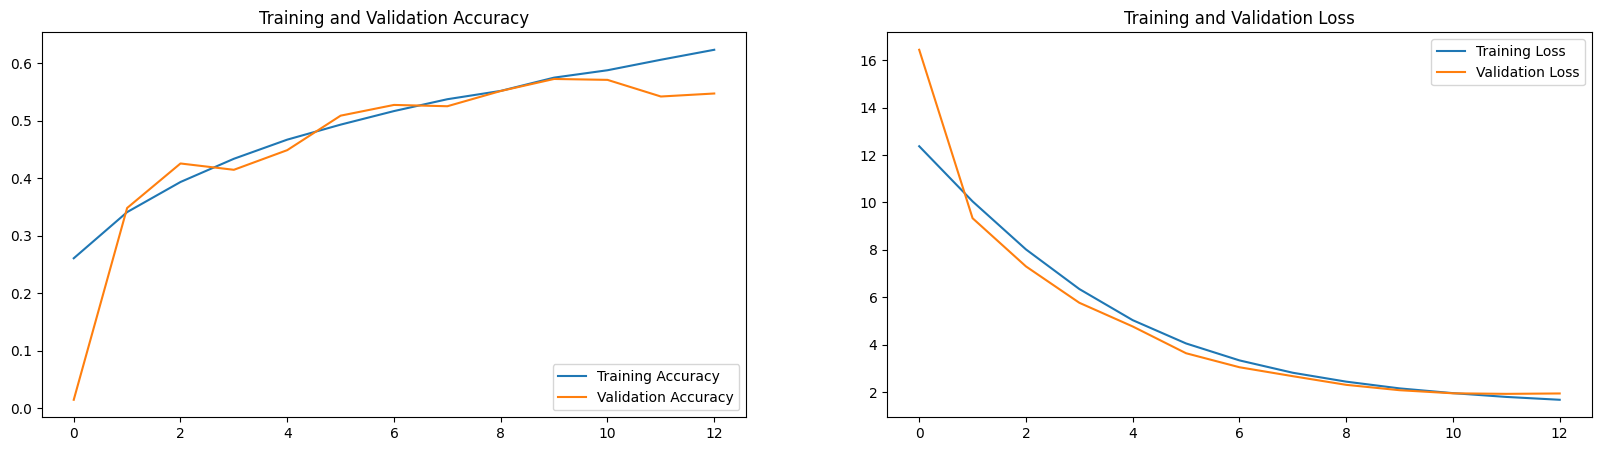

In [ ]:
plot_training_history(history_CNN2)

113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step


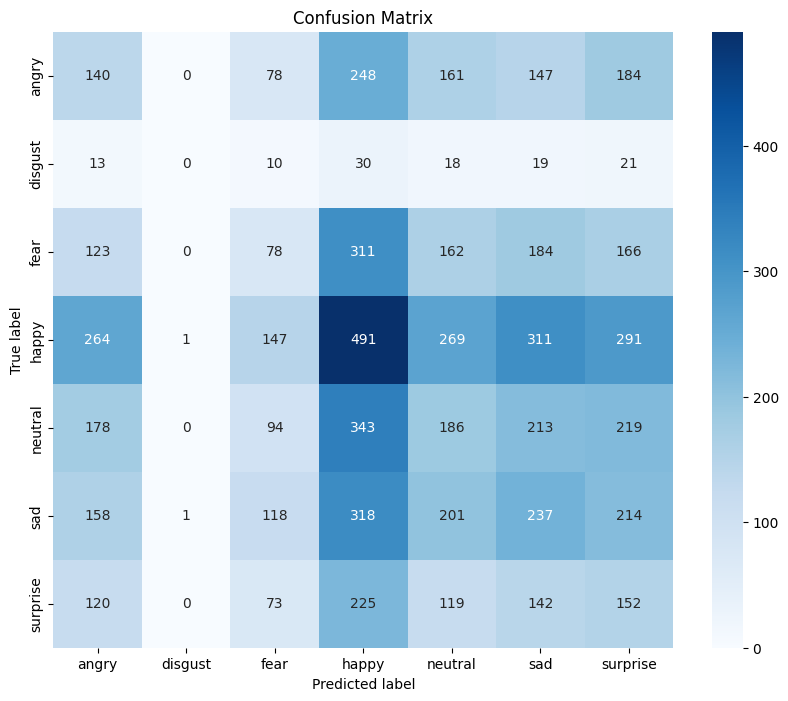

In [ ]:
true_classes = test_generator.classes
predicted_classes = np.argmax(
    CNN1.predict(
        test_generator,
        steps=int(np.ceil(test_generator.samples / test_generator.batch_size))
    ),
    axis=1
)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.15      0.14       958
     disgust       0.00      0.00      0.00       111
        fear       0.13      0.08      0.10      1024
       happy       0.25      0.28      0.26      1774
     neutral       0.17      0.15      0.16      1233
         sad       0.19      0.19      0.19      1247
    surprise       0.12      0.18      0.15       831

    accuracy                           0.18      7178
   macro avg       0.14      0.15      0.14      7178
weighted avg       0.17      0.18      0.17      7178



**Too bad, augumentation's not helping, I will proceed for transfer learning then..**